In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler

import numpy as np
import matplotlib.pyplot as plt

import time
import os

from PIL import Image
from tempfile import TemporaryDirectory

import pandas as pd
import csv

import seaborn as sns

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        # transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data\direction\folder'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['005', '010', '015', '020', '025', '030', '035', '040', '045', '050', '055', '060', '065', '070', '075', '080', '085', '090', '095', '100', '105', '110', '115', '120', '125', '130', '135', '140', '145', '150', '155', '160', '165', '170', '175', '180']


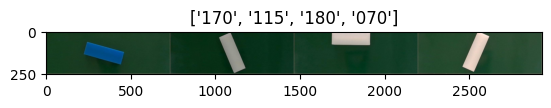

In [3]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Specify the path to save the best model parameters
    best_model_params_path = 'path\to\save\detect_angle.pt'
    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)#.float()

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward() #Tính đạo hàm
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path))
    return model

In [5]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}-true: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
# model_conv = torchvision.models.resnet34(weights="IMAGENET1K_V1")
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
# for param in model_conv.parameters():
#     param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 36)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [7]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 3.7067 Acc: 0.0404
val Loss: 3.3783 Acc: 0.1196

Epoch 1/24
----------
train Loss: 3.4625 Acc: 0.0613
val Loss: 3.2701 Acc: 0.0833

Epoch 2/24
----------
train Loss: 3.2738 Acc: 0.1054
val Loss: 2.9707 Acc: 0.1600

Epoch 3/24
----------
train Loss: 3.1284 Acc: 0.1275
val Loss: 2.7089 Acc: 0.2358

Epoch 4/24
----------
train Loss: 2.9934 Acc: 0.1500
val Loss: 2.5758 Acc: 0.2762

Epoch 5/24
----------
train Loss: 2.8871 Acc: 0.1725
val Loss: 2.5287 Acc: 0.2846

Epoch 6/24
----------
train Loss: 2.7691 Acc: 0.2042
val Loss: 2.4252 Acc: 0.2617

Epoch 7/24
----------
train Loss: 2.5147 Acc: 0.3088
val Loss: 2.2200 Acc: 0.3704

Epoch 8/24
----------
train Loss: 2.5000 Acc: 0.3275
val Loss: 2.1420 Acc: 0.3838

Epoch 9/24
----------
train Loss: 2.4826 Acc: 0.3213
val Loss: 2.1583 Acc: 0.4133

Epoch 10/24
----------
train Loss: 2.4860 Acc: 0.3308
val Loss: 2.1414 Acc: 0.4158

Epoch 11/24
----------
train Loss: 2.4849 Acc: 0.3188
val Loss: 2.1308 Acc: 0.4154

Ep

[[55.  9.  0. ...  0.  6. 20.]
 [15. 36.  7. ...  0. 10. 12.]
 [ 5.  9. 53. ...  1. 14.  2.]
 ...
 [ 2.  6.  3. ... 26. 34.  4.]
 [ 6.  6.  0. ...  4. 65.  9.]
 [19.  4.  0. ...  0. 15. 44.]]


Text(0.5, 80.7222222222222, 'Predicted label')

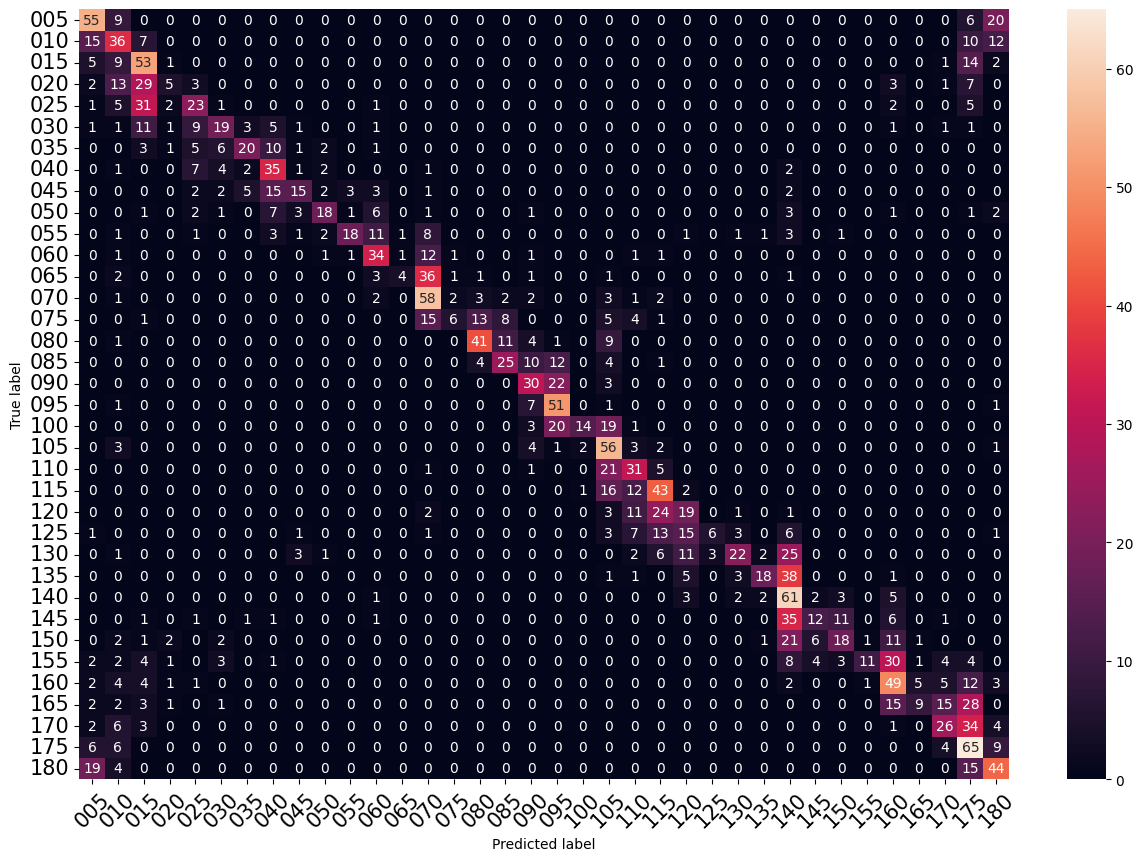

In [12]:
nb_classes = 36
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_conv(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
print(confusion_matrix)
plt.figure(figsize=(15,10))

# class_names_list = list(class_names.values())
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='center',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

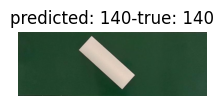

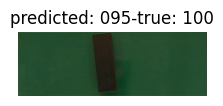

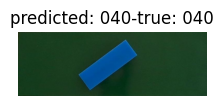

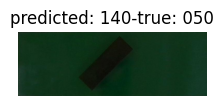

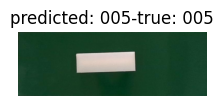

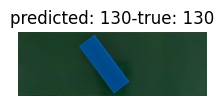

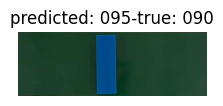

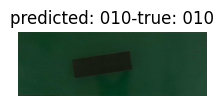

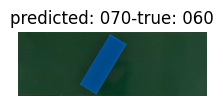

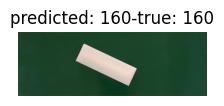

In [15]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [10]:
def check_image(csv_path,name):
    with open(csv_path, "r") as csvfile:

    # Create reader
        reader = csv.reader(csvfile, delimiter=",")
        for row in reader:
            if name in row:
                num_row =reader.line_num
                # Print number of rows
                print(f"Hàng {num_row} có chứa {name}")   
    return num_row

csv_path = "D:\hoctap\deeplearning\customDataset\data\data.csv"
name = "Image_0007.jpg"
labels = check_image(csv_path,name)
print(labels)
# check_image(csv_path,name)

Hàng 9 có chứa Image_0007.jpg
9


In [11]:
def visualize_model_predictions(model,img_path,csv_path):
    was_training = model.training
    model.eval()
    df = pd.read_csv(csv_path)
    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)
    name = os.path.basename(img_path)
    row = check_image(csv_path,name)
    labels = df.iloc[row-2 ,6]
    

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}- true: {labels}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)
        

Hàng 6 có chứa Image_0004.jpg


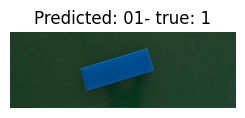

In [13]:
visualize_model_predictions(
    model_conv,
    img_path='path\to\image.jpg',
    csv_path="path\to\data.csv"
)

plt.ioff()
plt.show()

Hàng 1171 có chứa Image_1169.jpg


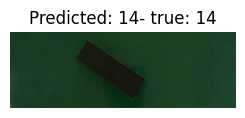

In [14]:
# Create an instance of ResNet18
model_conv = models.resnet18()
# Replace the fully connected layer with a new one having 2 output units
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 18)
model_conv = model_conv.to(device)
# Load the state dictionary into the ResNet18 model
state_dict = torch.load('path\to\detect_angle.pt')

# Load the adapted state dictionary into the model
model_conv.load_state_dict(state_dict)

model_conv.eval()  # Set the model to evaluation mode
visualize_model_predictions(
    model_conv,
    img_path='path\to\image.jpg',
    csv_path="path\to\data.csv"
)

plt.ioff()
plt.show()